<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/advi_beta_binom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADVI from scratch in JAX 

Authors: karm-patel@, murphyk@

In this notebook we apply ADVI (automatic differentiation variational inference) to the beta-binomial model, using a Normal Distribution as Variational Posterior. This involves a change of variable from the unconstrained z in R space to the constrained theta in [0,1] space.

In [1]:
try:
    import jax
except ModuleNotFoundError:
    %pip install -qqq jax jaxlib
    import jax

import jax.numpy as jnp
from jax import lax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    import optax
except ModuleNotFoundError:
    %pip install -qqq optax
    import optax

try:
    from rich import print
except ModuleNotFoundError:
    %pip install -qqq rich
    from rich import print

try:
    from tqdm import trange
except ModuleNotFoundError:
    %pip install -qqq tqdm
    from tqdm import trange


import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qqq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml


warnings.filterwarnings("ignore")
dist = tfp.distributions

plt.rc("font", size=10)  # controls default text sizes
plt.rc("axes", labelsize=12)  # fontsize of the x and y labels
plt.rc("legend", fontsize=12)  # legend fontsize
plt.rc("figure", titlesize=15)  # fontsize of the figure title

pml.latexify(width_scale_factor=2, fig_height=1.5)

Note: you may need to restart the kernel to use updated packages.


## Functions 
Helper functions which will be used later

In [2]:
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)


def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)


def transform_fn(x):
    return 1 / (1 + jnp.exp(-x))  # sigmoid


def positivity_fn(x):
    return jnp.log(1 + jnp.exp(x))  # softplus


def variational_distribution_q(params):
    loc = params["loc"]
    scale = positivity_fn(params["scale"])  # apply softplus
    return dist.Normal(loc, scale)


jacobian_fn = jax.jacfwd(transform_fn)  # define function to find jacobian for tranform_fun

## Dataset
Now, we will create the dataset. we sample `theta_true` (probability of occurring head) random variable from the prior distribution which is Beta in this case. Then we sample `n_samples` coin tosses from likelihood distribution which is Bernouli in this case. 

In [4]:
# Use same data as https://github.com/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]

## Prior, Likelihood, and True Posterior  
For coin toss problem, since we know the closed form solution of posterior, we compare the distributions of Prior, Likelihood, and True Posterior below.

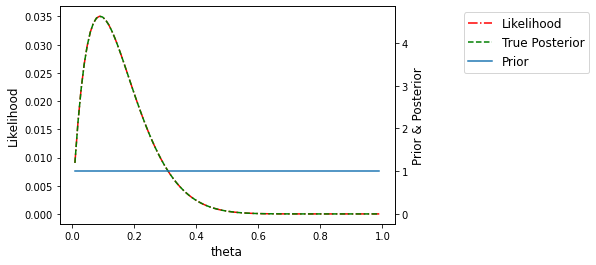

In [5]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
(plt2,) = ax2.plot(theta_range, exact_posterior.prob(theta_range), "g--", label="True Posterior")
(plt3,) = ax2.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
(plt1,) = ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax2.set_ylabel("Prior & Posterior")
ax2.legend(handles=[plt1, plt2, plt3], bbox_to_anchor=(1.6, 1));

## Optimizing the ELBO
In order to minimize KL divergence between true posterior and variational distribution, we need to minimize the negative ELBO, as we describe below.

We start with the ELBO, which is given by:
\begin{align}
ELBO(\psi) &= E_{z \sim q(z|\psi)} \left[
  p(\mathcal{D}|z) + \log p(z) - \log q(z|\psi) \right]
\end{align}
where 
$\psi = (\mu, \sigma)$ are the variational parameters,
$p(\mathcal{D}|z) =  p(\mathcal{D}|\theta=\sigma(z))$
is the likelihood,
and the prior is given by the change of variables formula:
\begin{align}
p(z) &= p(\theta) | \frac{\partial \theta}{\partial z} |
 =  p(\theta) | J | 
\end{align}
where $J$ is the Jacobian of the $z \rightarrow \theta$ mapping.
We will use a Monte Carlo approximation of the expectation over $z$.
We also apply the reparameterization trick
to replace $z \sim q(z|\psi)$ with
\begin{align}
\epsilon &\sim \mathcal{N}(0,1 ) \\
z &= \mu + \sigma \epsilon
\end{align}
Putting it altogether our estimate for the negative ELBO (for a single sample of $\epsilon$) is
\begin{align}
-L(\psi; z) &=  -( \log p(\mathcal{D}|\theta ) 
+\log p( \theta)   + \log|J_\boldsymbol{\sigma}(z)|) 
+ \log q(z|\psi)
\end{align}





In [6]:
def log_prior_likelihood_jacobian(normal_sample, dataset):
    theta = transform_fn(normal_sample)  # transform normal sample to beta sample
    likelihood_log_prob = likelihood_dist(theta).log_prob(dataset).sum()  # log probability of likelihood
    prior_log_prob = prior_dist().log_prob(theta)  # log probability of prior
    log_det_jacob = jnp.log(
        jnp.abs(jnp.linalg.det(jacobian_fn(normal_sample).reshape(1, 1)))
    )  # log of determinant of jacobian
    return likelihood_log_prob + prior_log_prob + log_det_jacob

In [7]:
# reference: https://code-first-ml.github.io/book2/notebooks/introduction/variational.html
def negative_elbo(params, dataset, n_samples=10, key=jax.random.PRNGKey(1)):

    q = variational_distribution_q(params)  # Normal distribution.
    q_loc, q_scale = q.loc, q.scale

    std_normal = dist.Normal(0, 1)
    sample_set = std_normal.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    sample_set = q_loc + q_scale * sample_set  # reparameterization trick

    # calculate log joint for each sample of z
    p_log_prob = jax.vmap(log_prior_likelihood_jacobian, in_axes=(0, None))(sample_set, dataset)

    return jnp.mean(q.log_prob(sample_set) - p_log_prob)

We now apply stochastic gradient descent to minimize negative ELBO and optimize the variational parameters (`loc` and `scale`)

In [8]:
loss_and_grad_fn = jax.value_and_grad(negative_elbo, argnums=(0))
loss_and_grad_fn = jax.jit(loss_and_grad_fn)  # jit the loss_and_grad function

params = {"loc": 0.0, "scale": 0.5}
elbo, grads = loss_and_grad_fn(params, dataset)

print(f"loss: {elbo}")
print(f"grads:\n loc: {grads['loc']}\n scale: {grads['scale']} ")

optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

loss: 9.09147834777832

grads:
 loc: 4.692040920257568
 scale: 0.6960504651069641

In [9]:
# jax scannable function for training
def train_step(carry, data_output):

    # take carry data
    key = carry["key"]
    elbo = carry["elbo"]
    grads = carry["grads"]
    params = carry["params"]
    opt_state = carry["opt_state"]
    updates = carry["updates"]

    # training
    key, subkey = jax.random.split(key)
    elbo, grads = loss_and_grad_fn(params, dataset, key=subkey)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # forward carry to next iteration by storing it
    carry = {"key": subkey, "elbo": elbo, "grads": grads, "params": params, "opt_state": opt_state, "updates": updates}

    output = {"elbo": elbo, "params": params}

    return carry, output

In [10]:
%%time

# dummy iteration to pass carry to jax scannale function train()
key, subkey = jax.random.split(key)
elbo, grads = loss_and_grad_fn(params, dataset, key=subkey)
updates, opt_state = optimizer.update(grads, opt_state)
params = optax.apply_updates(params, updates)

carry = {"key": key, "elbo": elbo, "grads": grads, "params": params, "opt_state": opt_state, "updates": updates}

num_iter = 1000
elbos = np.empty(num_iter)

# apply scan() to optimize training loop
last_carry, output = lax.scan(train_step, carry, elbos)

elbo = output["elbo"]
params = output["params"]
optimized_params = last_carry["params"]

CPU times: user 2.03 s, sys: 20.4 ms, total: 2.05 s
Wall time: 1.96 s


In [29]:
optimized_params = jax.tree_map(lambda x: x[-100:].mean(), output["params"])
optimized_params

{'loc': DeviceArray(-1.9149526, dtype=float32),
 'scale': DeviceArray(0.21098873, dtype=float32)}

In [30]:
print(params["loc"].shape)
print(params["scale"].shape)

(1000,)

(1000,)

We now plot the ELBO  

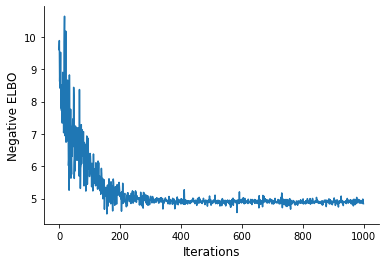

In [31]:
plt.figure()
plt.plot(elbo)
plt.xlabel("Iterations")
plt.ylabel("Negative ELBO")
sns.despine()
pml.savefig("advi_beta_binom_jax_loss.pdf")

We can see that after 200 iterations ELBO is optimized and not changing too much.

## Samples using Optimized parameters 

Now, we take 1000 samples from variational distribution (Normal) and transform them into true posterior distribution (Beta) by applying `tranform_fn` (sigmoid) on samples. Then we compare density of samples with exact posterior.

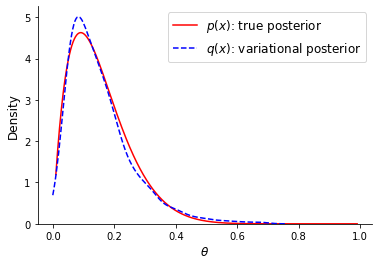

In [32]:
q_learned = variational_distribution_q(optimized_params)
key = jax.random.PRNGKey(128)
q_learned_samples = q_learned.sample(1000, seed=key)  # q(z|D)
transformed_samples = transform_fn(q_learned_samples)  # transform Normal samples into Beta samples

theta_range = jnp.linspace(0.01, 0.99, 1000)
plt.figure()
plt.plot(theta_range, exact_posterior.prob(theta_range), "r", label="$p(x)$: true posterior")
sns.kdeplot(
    transformed_samples,
    color="blue",
    label="$q(x)$: variational posterior",
    bw_adjust=1,
    clip=(0.0, 1.0),
    linestyle="--",
)

plt.xlabel("$\\theta$")
plt.legend()  # bbox_to_anchor=(1.5, 1));
sns.despine()

pml.savefig("advi_beta_binom_jax_posterior.pdf")

We can see that the learned `q(x)` is a reasonably good approximation to the true posterior. It seems to have support over negative theta but this is an artefact of KDE.


In [33]:
# print(transformed_samples)
print(len(transformed_samples))
print(jnp.sum(transformed_samples < 0))  # all samples of thetas should be in [0,1]
print(jnp.sum(transformed_samples > 1))  # all samples of thetas should be in [0,1]

1000

0

0

In [34]:
print(q_learned)
print(q_learned.mean())
print(jnp.sqrt(q_learned.variance()))

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)

-1.9149526

0.8041958

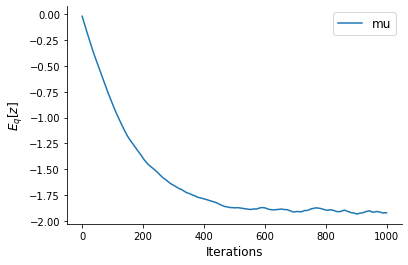

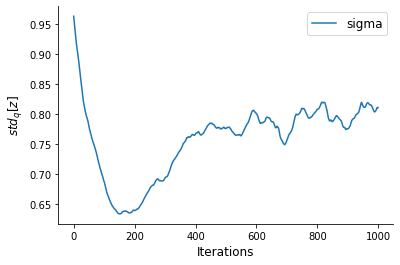

In [35]:
locs, scales = params["loc"], params["scale"]
sigmas = positivity_fn(jnp.array(scales))
plt.figure()
plt.plot(locs, label="mu")
plt.xlabel("Iterations")
plt.ylabel("$E_q[z]$")
plt.legend()
sns.despine()
pml.savefig("advi_beta_binom_jax_post_mu_vs_time.pdf")
plt.show()

plt.figure()
plt.plot(sigmas, label="sigma")
plt.xlabel("Iterations")
# plt.ylabel(r'$\sqrt{\text{var}(z)}')
plt.ylabel("$std_{q}[z]$")
plt.legend()
sns.despine()
pml.savefig("advi_beta_binom_jax_post_sigma_vs_time.pdf")
plt.show()

## References:

1. ADVI paper: https://arxiv.org/abs/1603.00788
2. Blog: https://code-first-ml.github.io/book2/notebooks/introduction/variational.html
3. Blog: https://luiarthur.github.io/statorial/varinf/introvi/
4. Video: https://www.youtube.com/watch?v=HxQ94L8n0vU 
5. Github issue: https://github.com/pyro-ppl/pyro/issues/3016#:~:text=loc%3D%27upper%20right%27)-,Bandwidth%20adjustment,-Another%20thing%20to
6. Blog: https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html